In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)

In [2]:
 def plot_stuff(model,X,y,x_biased,name='Naive DNN'):
    predictions = np.array(model(torch.Tensor(X).float().to(device)).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    x_biased = x_biased *250 
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m_t = x_biased
    sorted_m = np.argsort(m_t)
    scores = predictions[sorted_m].reshape(-1,100)
    m_t = m_t[sorted_m]
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=20,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()

In [3]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

In [4]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = "cpu"
traindataset = DataSet(samples=train[::,1:-1],
                       labels=train[::,-1].astype('int32'),
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val[:,-1].astype('int32'),
                    m = val[:,0])
test = files["test"]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

print('device:', device)

device: cuda:0


# Tests

In [6]:
params = {'epochs'     : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

strength 99.99999999999991
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (164.3s)
 Train: loss:0.0070, acc:29% || Val: loss: 0.1951, acc:80%, R50: 4.6441, 1/JSD: 432.1399
Epoch:0200/0200  (297.3s)
 Train: loss:0.0070, acc:30% || Val: loss: 0.1951, acc:80%, R50: 4.6697, 1/JSD: 427.1522


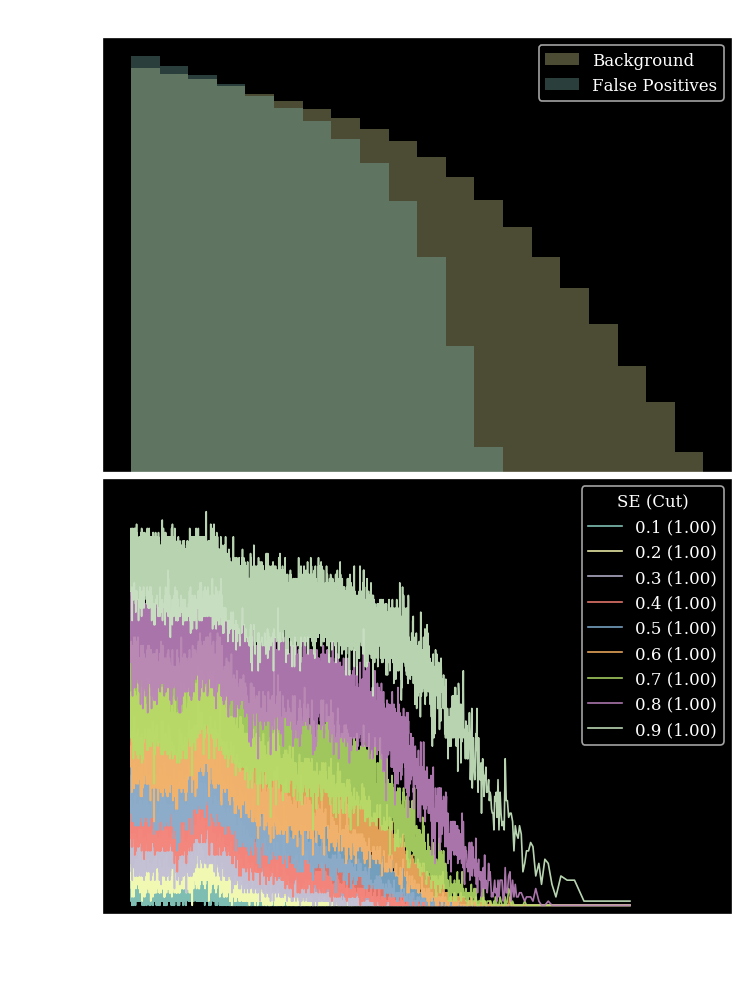

strength 9.999999999999996
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (137.9s)
 Train: loss:0.0641, acc:29% || Val: loss: 0.1948, acc:80%, R50: 5.5394, 1/JSD: 615.0636
Epoch:0200/0200  (265.4s)
 Train: loss:0.0459, acc:55% || Val: loss: 0.1062, acc:83%, R50: 8.1728, 1/JSD: 1590.9167


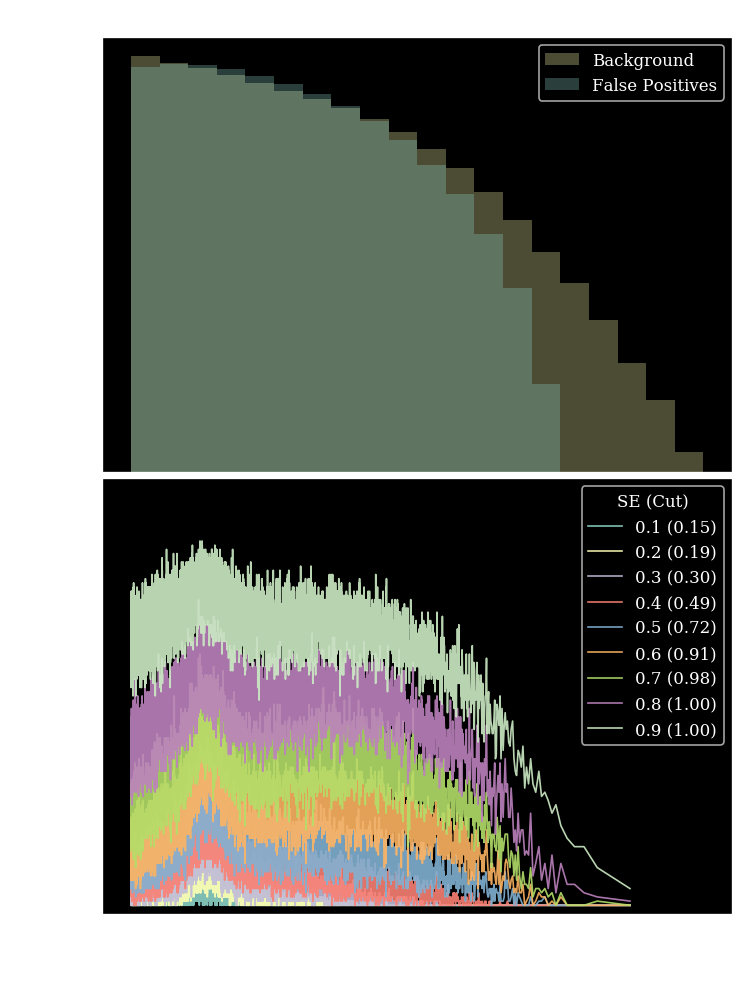

strength 1.0
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (154.9s)
 Train: loss:0.1396, acc:75% || Val: loss: 0.0593, acc:86%, R50: 21.3261, 1/JSD: 54.2721
Epoch:0200/0200  (360.5s)
 Train: loss:0.1249, acc:77% || Val: loss: 0.0517, acc:85%, R50: 22.0382, 1/JSD: 49.3448


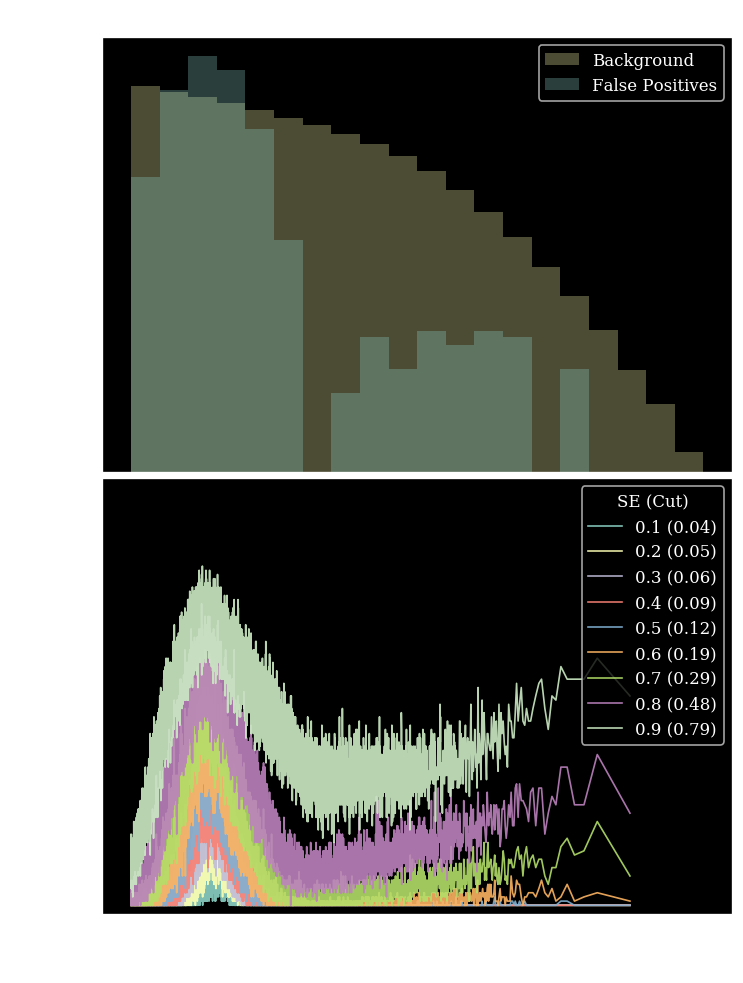

strength 0.1
Entering Training...
Epoch:0001/0200  (8.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (231.5s)
 Train: loss:0.1901, acc:80% || Val: loss: 0.0395, acc:85%, R50: 22.5780, 1/JSD: 51.1454
Epoch:0200/0200  (436.3s)
 Train: loss:0.1795, acc:81% || Val: loss: 0.0406, acc:85%, R50: 23.3844, 1/JSD: 43.0541


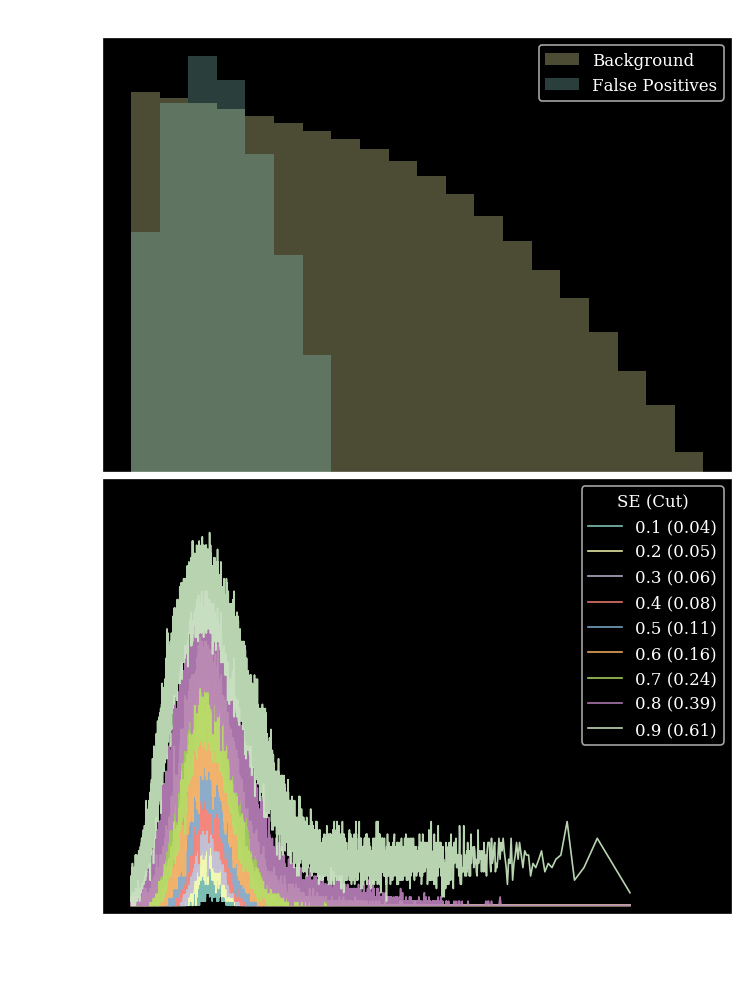

strength 0.01
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (205.0s)
 Train: loss:0.1992, acc:81% || Val: loss: 0.0368, acc:84%, R50: 22.6945, 1/JSD: 56.8668
Epoch:0200/0200  (439.6s)
 Train: loss:0.1871, acc:81% || Val: loss: 0.0362, acc:85%, R50: 23.8319, 1/JSD: 41.2713


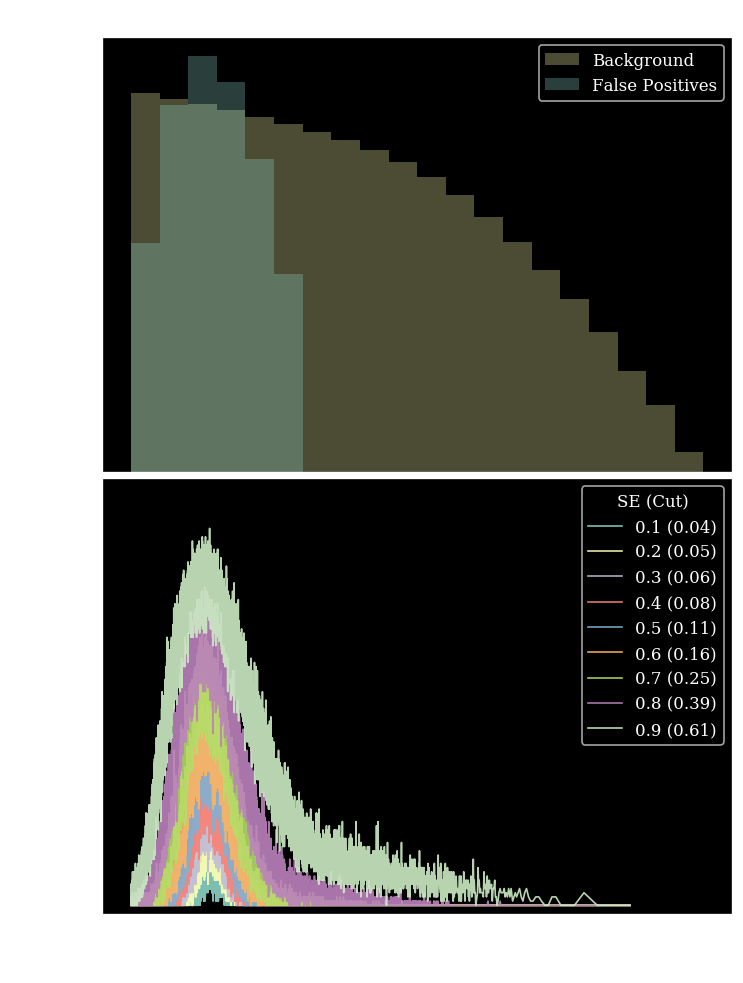

strength 0.0010000000000000002
Entering Training...
Epoch:0001/0200  (9.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (243.9s)
 Train: loss:0.2001, acc:81% || Val: loss: 0.0369, acc:84%, R50: 22.7414, 1/JSD: 56.7147
Epoch:0200/0200  (498.8s)
 Train: loss:0.1880, acc:81% || Val: loss: 0.0362, acc:85%, R50: 23.8388, 1/JSD: 41.0450


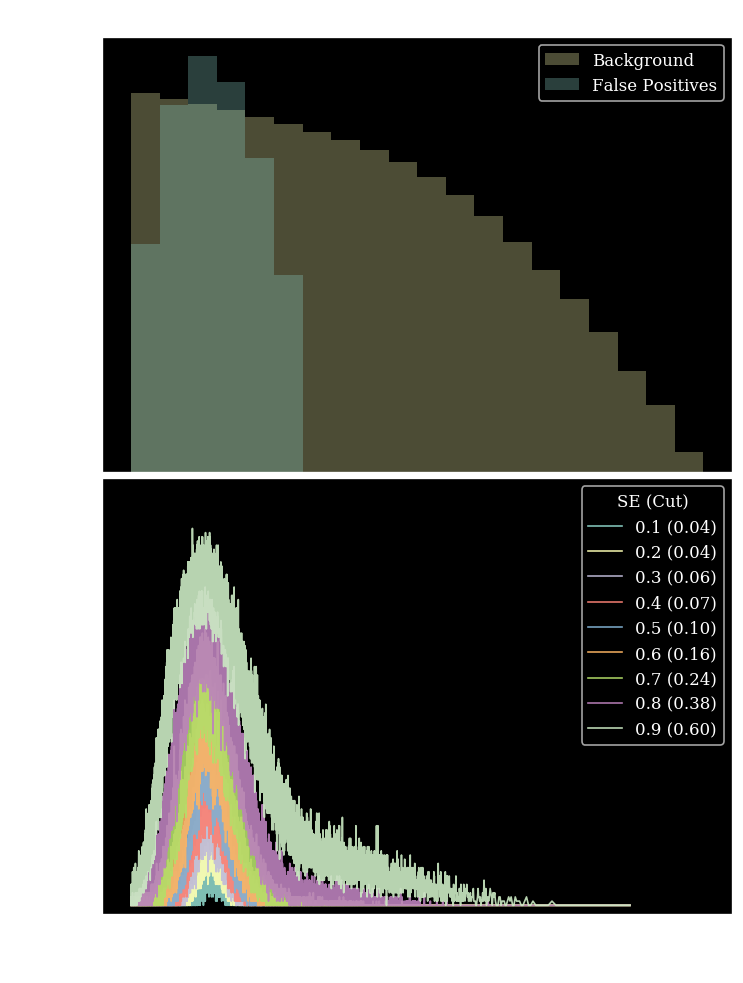

In [7]:
for i,strength in enumerate([100,10,1,1e-1,1e-2,1e-3]):
    frac = strength/(1+strength)
    print("strength",frac/(1-frac))
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNflatLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    plot_stuff(model=model_L,name="Flat DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0])

In [ ]:
asdfasf 

# Other tests

## MSE 

In [8]:
params = {'epochs' : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'device'     : device,
          'pass_x_biased':False
         }
metrics_train = Metrics()
metrics_val = Metrics(validation=True)

In [9]:
torch.manual_seed(777)
model = Classifier().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=2e-1,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
criterion = WeightedMSE(labels=traindataset.labels)
log=Logger("./logs/logWFCNmse.txt")
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params,
          optimizer= optimizer,
          loss=criterion,
          log=log,
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Entering Training...
Epoch:0001/0200  (11.0 s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0463, acc:20%, R50: 2.4155, 1/JSD: 4256.6534
Epoch:0100/0200  (151.2s)
 Train: loss:0.1972, acc:79% || Val: loss: 0.0334, acc:83%, R50: 22.7148, 1/JSD: 55.5717
Epoch:0200/0200  (285.8s)
 Train: loss:0.1810, acc:80% || Val: loss: 0.0291, acc:82%, R50: 23.7239, 1/JSD: 46.0874


In [10]:
plot_stuff(model=model,name="Naive DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0])

RuntimeError: CUDA out of memory. Tried to allocate 208.00 MiB (GPU 0; 11.78 GiB total capacity; 1.06 GiB already allocated; 49.50 MiB free; 1.18 GiB reserved in total by PyTorch)

In [ ]:
print(torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5))

In [ ]:
model_L = Classifier().to(device)

In [ ]:
model_L = model_L.to(device)

In [ ]:
frac=1e-1
print("strength",frac/(1-frac))
params = {'epochs'     : 1400,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }
metrics_train_L = Metrics()
metrics_val_L = Metrics(validation=True)

torch.manual_seed(777)
optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
log=Logger("./logs/logWFCNflatLoss({:.2f}).txt".format(frac))
model_L.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
            log=log,
          #scheduler=scheduler,
          metrics=[metrics_train_L,metrics_val_L])
plot_stuff(model=model_L,name="Flat DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0])

In [ ]:
model_cpu = model_L.to('cpu')
preds = model_cpu(torch.from_numpy(test[:,1:11]).float())
preds = np.array(preds.tolist()).flatten()
labels = test[:,-1]
_,bins,_ = plt.hist(preds[labels==1],bins=50,density=True,alpha=0.5,label='bckg')
plt.hist(preds[labels==0],bins=50,density=True,alpha=0.5,label='signal')
plt.legend()
plt.xlabel('scores')
plt.show()

In [ ]:
model_cpu = model_L.to('cpu')
preds = model_cpu(torch.from_numpy(test[:,1:11]).float())
preds = np.array(preds.tolist()).flatten()
labels = test[:,-1]
_,bins,_ = plt.hist(preds[labels==1],bins=50,density=True,alpha=0.5,label='bckg')
plt.hist(preds[labels==0],bins=bins,density=True,alpha=0.5,label='signal')
plt.legend()
plt.xlabel('scores')
plt.show()

In [ ]:
preds.min()

In [ ]:
np.linspace(1,50,50).reshape(5,10) *np.arange(1,11)